# Tutorial 10 – Model Selection

### This notebook contains all the sample code and solutions to the model assessment for model selection.
#### You will learn:

1. The use of validation dataset
2. Linear regression models with regularizations.
3. Post pruning decision tree with complexity penalty
4. Cross-validation

# 1. Linear regression using the Normal Equation

## 1.1 First, let's generate a dataset for linear regression: $y=3*x+4+\epsilon$

In [1]:
import numpy.random as rnd # this is a library for random number generation

rnd.seed(1) #设置了随机数生成器的种子值

X = 2 * rnd.rand(100, 1) 
# 生成了一个100行1列的数组X。rnd.rand(100, 1)用于生成一个100行1列的随机数组，其中每个元素都是在[0, 1)之间的随机数。将其乘以2可以将其范围扩展到[0, 2)。生成的数组将被用作输入特征。

y = 4 + 3 * X + rnd.randn(100, 1)
# 生成了一个100行1列的数组y。
# rnd.randn(100, 1)用于生成一个100行1列的随机数组，其中每个元素都是服从标准正态分布的随机数（均值为0，标准差为1）。
# 这个数组的作用是添加随机噪声到生成的数据中，使得数据更加真实。y代表输出标签，它是由输入特征X和一些随机噪声线性组合而成的。
# y的值是由公式y = 4 + 3 * X + e计算而来，其中e是一个服从标准正态分布的随机数，用来模拟随机噪声。

## 1.2 Let's take a look at the data distribution

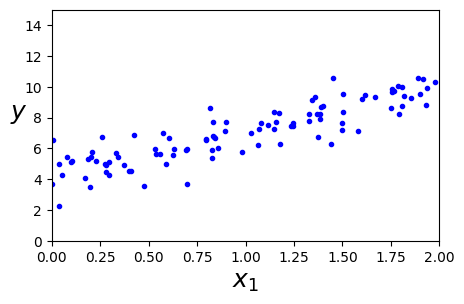

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5,3)
plt.plot(X, y, "b.") # creates a scatter plot with blue dots
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.savefig("generated_data_plot.png")
plt.show()

## 1.3 Then, we can find a linear regression model from the library and fit the data. The fit result shows a regression line of 

In [3]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression() # define your model
lin_reg.fit(X, y)  # fit your model using the data

#this step shows the intercept and coefficients of your fit result
print('Slope is %f, Intercept is %f'%(lin_reg.coef_, lin_reg.intercept_))
print('Linear Function is y=%f * x + %f'%(lin_reg.coef_, lin_reg.intercept_))

Slope is 2.842463, Intercept is 4.236957
Linear Function is y=2.842463 * x + 4.236957


## 1.4 After the model is trained, we can use it to predict the Y values of new data points given X values

We can see the regression line predict the Y-values as the black dot. The real Y values are represented as yellow stars.

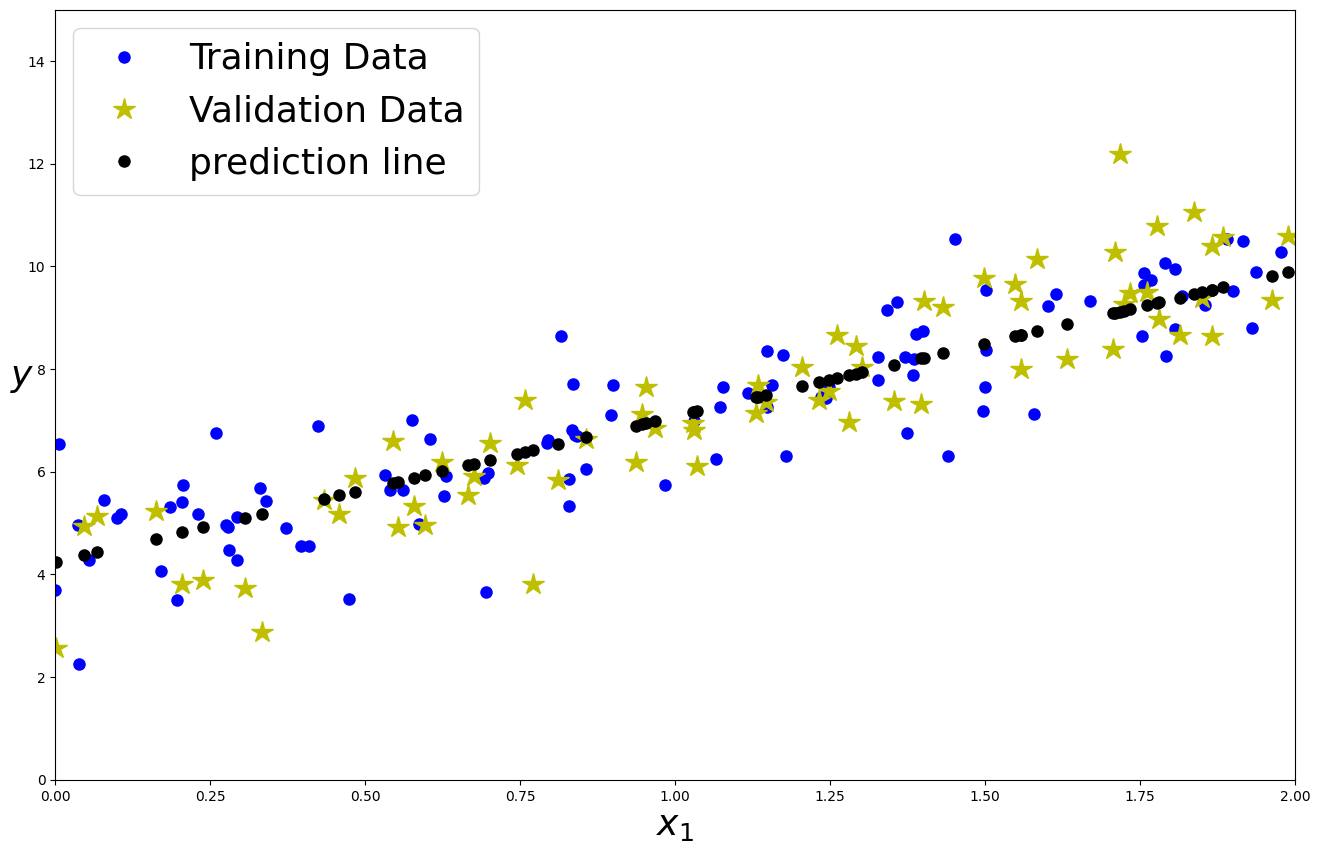

In [4]:
X_new=3 * rnd.rand(100, 1) # here we generate a set of new data points of X
Y_new = 4 + 3 * X_new + rnd.randn(100, 1) # here we generate a set of new data points of Y
plt.figure(figsize=(16,10))
Y_new_predict=lin_reg.predict(X_new) # we use the regression model to predict the Y value of the new data points
plt.plot(X, y, "b.",markersize=16)
plt.plot(X_new,Y_new,"*",color='y',markersize=16)
plt.plot(X_new,Y_new_predict,".",color='black',markersize=16)
plt.xlabel("$x_1$", fontsize=26)
plt.ylabel("$y$", rotation=0, fontsize=26)
plt.axis([0, 2, 0, 15])
plt.legend(['Training Data','Validation Data','prediction line'],fontsize=26)

plt.show()

## 1.5 Evaluate the performance of regression line using new data points.
Here we can use some evaluation metric to evaluate the performance of your data.
We try R-square to evaluate.
Check https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules for more evaluation metrics

In [5]:
from sklearn.metrics import r2_score 
# 从Scikit-learn库中导入r2_score函数，用于计算R²分数，
# R²是一种常用的回归模型评估指标，表示模型预测值和真实值之间的相关性程度。

from sklearn.metrics import mean_absolute_error
# 用于计算平均绝对误差（MAE），是回归模型的另一种评估指标，表示预测值和真实值之间的平均绝对差距。

evaluation_result=mean_absolute_error(Y_new, Y_new_predict)
# 使用mean_absolute_error函数计算Y_new和Y_new_predict之间的平均绝对误差，并将结果保存在evaluation_result变量中

print('MAE=%f' %evaluation_result)
# 使用字符串格式化将evaluation_result的值嵌入到输出字符串中

MAE=0.750172


# 2. Deal with model complexity - Ridge Regression

reference: https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/

### 2.1 Lets fist generate a dataset from y=Sin(x)+noise for fitting 

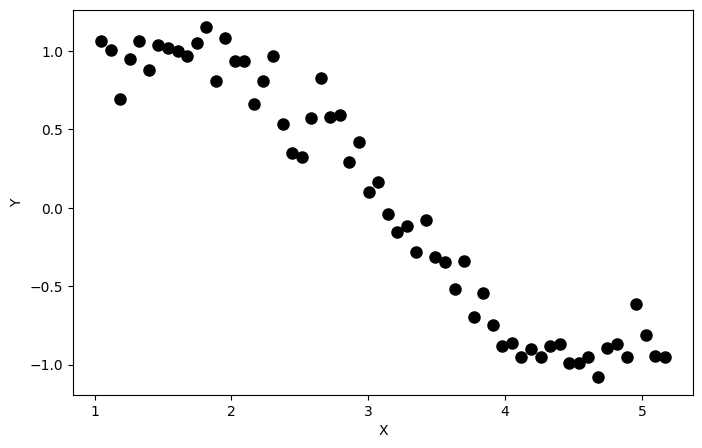

          x         y       x^2       x^3       x^4       x^5       x^6  \
0  1.047198  1.065763  1.096623  1.148381  1.202581  1.259340  1.318778   
1  1.117011  1.006086  1.247713  1.393709  1.556788  1.738948  1.942424   
2  1.186824  0.695374  1.408551  1.671702  1.984016  2.354677  2.794587   
3  1.256637  0.949799  1.579137  1.984402  2.493673  3.133642  3.937850   
4  1.326450  1.063496  1.759470  2.333850  3.095735  4.106339  5.446854   

        x^7       x^8        x^9       x^10       x^11       x^12       x^13  \
0  1.381021  1.446202   1.514459   1.585938   1.660790   1.739176   1.821260   
1  2.169709  2.423588   2.707173   3.023942   3.377775   3.773011   4.214494   
2  3.316683  3.936319   4.671717   5.544505   6.580351   7.809718   9.268760   
3  4.948448  6.218404   7.814277   9.819710  12.339811  15.506664  19.486248   
4  7.224981  9.583578  12.712139  16.862020  22.366630  29.668222  39.353420   

        x^14       x^15  
0   1.907219   1.997235  
1   4.707635   5

In [6]:
# 用于生成一个具有噪声的正弦函数数据集，并且为这个数据集添加一些新的特征

#Importing libraries. The same will be used throughout the article.
import numpy as np # 导入numpy库，用于进行数学运算和数组操作

import pandas as pd # 导入pandas库，用于数据处理和分析

import random # 导入random库，用于生成随机数

import matplotlib.pyplot as plt # 导入matplotlib库，用于可视化数据
%matplotlib inline 

from matplotlib.pylab import rcParams  # rcParams用于设置全局绘图参数
plt.figure(figsize=(8,5))

#Define input array with angles from 60deg to 300deg converted to radians
x = np.array([i*np.pi/180 for i in range(60,300,4)])
# 创建了一个包含角度值的输入向量x，将60度到300度之间的角度以4度间隔转换为弧度

np.random.seed(10)  #Setting seed for reproducibility

y = np.sin(x) + np.random.normal(0,0.15,len(x)) 
# y是在x的基础上加上正态分布噪声后得到的输出向量
# 用np.sin函数生成一个正弦函数，并为该函数添加一些高斯噪声，噪声的均值为0，标准差为0.15

data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
# 将输入数组和带有噪声的正弦函数的值合并为一个DataFrame，并设置DataFrame的列名为'x'和'y

plt.plot(data['x'],data['y'],".",color='black',markersize=16)
# 用黑色的点图绘制数据集中的所有点，点的大小为1

plt.xlabel('X')
plt.ylabel('Y')
# 设置x轴和y轴的标签

plt.show()

# 循环迭代从2到15，为数据集添加新的特征，这些特征是输入数据的i次方
# 特征的名称存储在变量colname中，并将特征添加到DataFrame中
#create new variables for x^k
for i in range(2,16):  #power of 1 is already there
    colname = 'x^%d'%i #new var will be x_power 将i代入到字符串'x^%d'中，以形成新的列名。例如，当i为2时，colname的值将为'x^2'
    data[colname] = data['x']**i #**操作符表示乘方。将自变量'x'的i次幂作为新的列添加到数据集中，列名为colname
print(data.head())

## 2.2 We can use a complex models to fit, which may have overfitting issue:

for example, we can use **polynomial regression**:

$$y=a0+a1*x + a2*x^2+a3*x^3+...a15*x^{15}$$


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


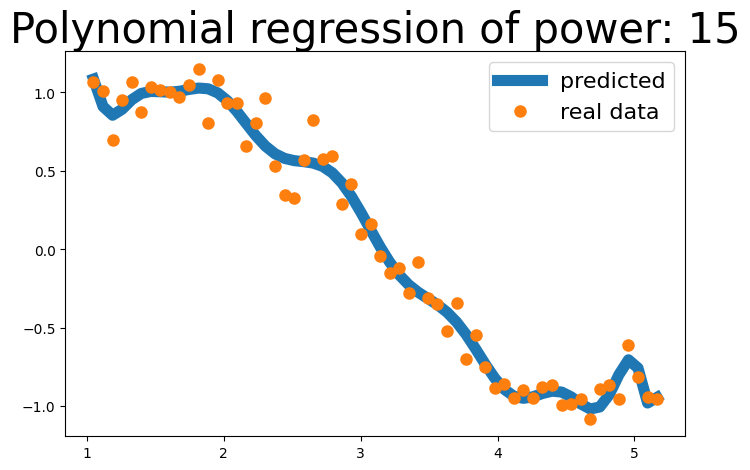

In [7]:
from sklearn.linear_model import LinearRegression
plt.figure(figsize=(8,5))

power=15 #设置多项式回归的次数为15次
predictors=['x'] # 创建一个包含一个元素“x”的列表。这个列表包含回归模型的预测变量
predictors.extend(['x^%d'%i for i in range(2,power+1)])#we extend the orignial feature x to the power of 2, 3, ..., 15
# 将“x”的幂次方扩展到2，3，...，15。这些幂次方将被添加到predictors列表中，以便在多项式回归模型中使用

linreg = LinearRegression(normalize=True) #set up the model. 
# If this parameter "normalize" is set to True, 
#the regressor X will be normalized before regression. 
#The normalization will be done by subtracting the mean and dividing it by L2 norm.
# 如果将“normalize”参数设置为True，则在回归之前将对回归器X进行归一化处理。归一化是通过减去平均值并除以L2范数来完成的

linreg.fit(data[predictors],data['y'])
# 对数据集进行多项式回归。回归使用predictors作为预测变量，'y'作为响应变量。
# fit（）函数用于拟合回归模型

y_pred = linreg.predict(data[predictors])
# 预测响应变量' y'。使用predict（）函数预测数据集中的响应变量

plt.plot(data['x'],y_pred,linewidth=8)
# 使用plot（）函数在图形上绘制预测值。'x'是自变量，y_pred是预测的因变量，linewidth是线条宽度

plt.plot(data['x'],data['y'],'.',markersize=16)
# 在图形上绘制真实值。'x'是自变量，'y'是真实的因变量，'.'是绘制真实值的符号，markersize是点的大小

plt.title('Polynomial regression of power: %d'%power,fontsize=30)

plt.legend(['predicted','real data'],fontsize=16)
# 在图形上添加图例。分别代表预测值和真实值，字体大小为16

plt.show()


### Let's take a look at the training error and coefficients from this fitting.

The training error is small. But the coefficients are very large.

In [8]:
print('Training Error= %f' %mean_absolute_error(data['y'], y_pred))
# 输出一个包含训练误差的信息。%f 是一个占位符，用于将 mean_absolute_error 函数的计算结果插入到输出信息中，该函数接收两个参数：data['y'] 和 y_pred

print('intercept=%f' %linreg.intercept_) # 输出截距

# 遍历每个系数，print系数
# len() 函数用于计算 linreg.coef_ 数组的长度，也就是包含系数的数量
for i in range(len(linreg.coef_)): #range() 函数用于指定生成的序列的长度，然后for循环来遍历该序列中的每个元素
    print('a%d=%f' %(i+1,linreg.coef_[i]))
    # %d 和 %f 占位符分别用于插入系数的索引和值。其中 linreg.coef_ 是一个包含所有系数的数组

Training Error= 0.083248
intercept=-36240.172610
a1=243814.425958
a2=-745746.453982
a3=1376007.604784
a4=-1713465.742562
a5=1526000.793269
a6=-1004675.801306
a7=498245.505730
a8=-187796.981320
a9=53840.949224
a10=-11655.420353
a11=1872.618263
a12=-216.342349
a13=16.982068
a14=-0.810593
a15=0.017751


## 2.3 Ridge regression set penalty to coefficient size:

## Regression penalty: α * (sum of square of coefficients)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Ridge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  FutureWarning,


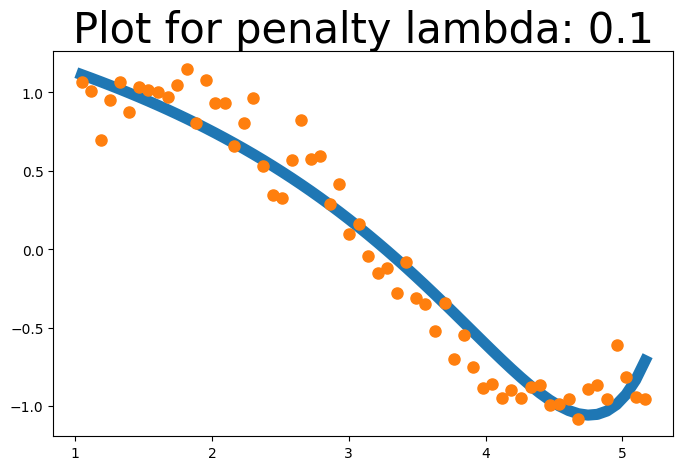

In [9]:
from sklearn.linear_model import Ridge
plt.figure(figsize=(8,5))

alpha=0.1 #the penlty term is set to be 0.1，定义了正则化函数，并将其设置为0.1
#Fit the model
ridgereg = Ridge(alpha=alpha,normalize=True) # 使用上面定义的alpha参数进行正则化，并将normalize参数设置为True以进行数据标准化处理
ridgereg.fit(data[predictors],data['y']) # 训练Ridge模型，以获得最优的模型参数
y_pred = ridgereg.predict(data[predictors]) # 使用训练好的Ridge模型ridgereg对数据集中的自变量data[predictors]进行预测

#Check if a plot is to be made for the entered alpha
plt.plot(data['x'],y_pred,linewidth=8) # 预测结果
plt.plot(data['x'],data['y'],'.',markersize=16) # 真实结果
plt.title('Plot for penalty lambda: %.3g'%alpha,fontsize=30)
plt.show()

### Let's take a look at the training error and coefficients from this fitting.

The training error is larger. But the coefficients are significantly reduced. The model is reduced to a simpler form.

In [10]:
print('Training Error= %f' %mean_absolute_error(data['y'], y_pred))
print('intercept=%f' %ridgereg.intercept_) # Ridge回归模型的截距(intercept)
for i in range(len(ridgereg.coef_)):
    print('a%d=%f' %(i+1,ridgereg.coef_[i]))

Training Error= 0.146744
intercept=1.392827
a1=-0.224699
a2=-0.033668
a3=-0.005179
a4=-0.000733
a5=-0.000091
a6=-0.000009
a7=-0.000000
a8=0.000000
a9=0.000000
a10=0.000000
a11=0.000000
a12=0.000000
a13=0.000000
a14=0.000000
a15=0.000000


## 3. Post pruning decision trees with complexity penalty for Breast Cancer Diagnostic
[Reference](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py)

The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is downloaded from: https://goo.gl/U2Uwz2

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Separating plane described above was obtained using Multisurface Method-Tree (MSM-T) [K. P. Bennett, “Decision Tree Construction Via Linear Programming.” Proceedings of the 4th Midwest Artificial Intelligence and Cognitive Science Society, pp. 97-101, 1992], a classification method which uses linear programming to construct a decision tree. Relevant features were selected using an exhaustive search in the space of 1-4 features and 1-3 separating planes.

The actual linear program used to obtain the separating plane in the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: “Robust Linear Programming Discrimination of Two Linearly Inseparable Sets”, Optimization Methods and Software 1, 1992, 23-34].

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

We load the attributes and class label for each digitized image of a fine needle aspirate (FNA) of a breast mass. 
The detailed measurement of a cell can be found here: [data description](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)

In [12]:
X,y = load_breast_cancer(return_X_y=True) #return_X_y=True时，将数据集的特征矩阵和标签向量分别赋值给X和y
#randomly split the dataset. By default, the test_size=0.25

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)  
# train_test_split函数将输入数据集X和y分割为训练集和测试集，
# 返回四个变量，分别为训练集的特征矩阵X_train、训练集的标签向量y_train、测试集的特征矩阵X_test和测试集的标签向量y_test

X[0]
# 输出数据集中的第一个样本的特征向量。X是一个二维数组，每一行代表一个样本，每一列代表一个特征。因此，X[0]是第一个样本的特征向量
# 特征矩阵是一个二维数组，其中每行表示一个样本，每列表示一个特征

array([1.799e+01, 1.038e+01, 1.228e+02, 1.001e+03, 1.184e-01, 2.776e-01,
       3.001e-01, 1.471e-01, 2.419e-01, 7.871e-02, 1.095e+00, 9.053e-01,
       8.589e+00, 1.534e+02, 6.399e-03, 4.904e-02, 5.373e-02, 1.587e-02,
       3.003e-02, 6.193e-03, 2.538e+01, 1.733e+01, 1.846e+02, 2.019e+03,
       1.622e-01, 6.656e-01, 7.119e-01, 2.654e-01, 4.601e-01, 1.189e-01])

In [13]:
y[0:20] # binary targets
# 提取标签向量'y'中前二十个元素[0，20）

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

### 3.1. Use cost_complexity_pruning_path to generage pentalties alpha

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

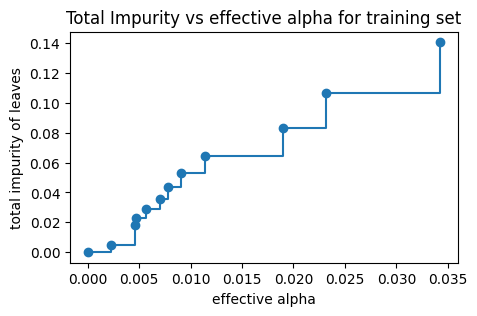

In [14]:
clf = DecisionTreeClassifier(random_state=0)
# 当我们需要多次运行相同的算法或模型，并比较它们的性能时，就需要设置相同的random_state

path = clf.cost_complexity_pruning_path(X_train, y_train) #seeking alpha
# 算出决策树分类器在一系列alpha参数取值下的总不纯度，
# 返回值path是一个带有ccp_alphas和impurities属性的对象，
# 其中ccp_alphas是一系列alpha参数的取值，impurities是对应的总不纯度

ccp_alphas, impurities = path.ccp_alphas, path.impurities #output apha and tree impurities

fig, ax = plt.subplots()
# 创建一个画布和一个轴对象，并将其分别赋值给fig和ax变量

ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post") # 在轴对象ax上绘制一条曲线
# ccp_alphas[:-1]是一系列alpha参数的取值（除去最后一个），impurities[:-1]是对应的总不纯度
# [:-1]表示从序列的第一个元素开始提取到倒数第二个元素的子序列，也就是去掉最后一个元素的子序列
# marker="o"表示绘制点的形状为圆圈，drawstyle="steps-post"表示绘制出阶梯状的曲线

ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

### 3.2. Use different penalty alpha to generate different tree structure.

In [15]:
clfs = [] #this list will be used to store a list of Decision Tree Models with different penalty alpha values.
for alpha in ccp_alphas: #循环迭代ccp_alphas列表中的所有元素，其中ccp_alphas包含了一系列惩罚系数
    print('the penalty term alpha is %f' %alpha) # 打印出当前惩罚系数的值，用来跟踪模型训练的进度
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=alpha) # induce a tree using the ccp_alpha value
    clf.fit(X_train, y_train) # 将定义的决策树分类器clf拟合到训练数据集X_train和标签集y_train上，得到当前惩罚系数下的决策树模型
    clfs.append(clf) #将拟合后的决策树分类器clf添加到之前定义的列表clfs中。循环结束后，clfs列表中将包含一系列惩罚系数不同的决策树模型

the penalty term alpha is 0.000000
the penalty term alpha is 0.002266
the penalty term alpha is 0.004647
the penalty term alpha is 0.004660
the penalty term alpha is 0.005634
the penalty term alpha is 0.007042
the penalty term alpha is 0.007842
the penalty term alpha is 0.009114
the penalty term alpha is 0.011444
the penalty term alpha is 0.018988
the penalty term alpha is 0.023142
the penalty term alpha is 0.034225
the penalty term alpha is 0.327298


### 3.2.1 The first tree using the first panelty alpha (ccp_alphas[0])

the first alphas is:  0.0


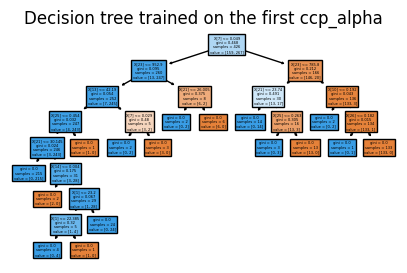

In [16]:
from sklearn.tree import plot_tree # plot_tree函数用于可视化决策树模型
print('the first alphas is: ', ccp_alphas[0]) #the first alpha value in the list of ccp_alphas generated.
plot_tree(clfs[0], filled=True) # filled=True参数用于使可视化的决策树节点填充颜色，以突出显示不同的决策路径
plt.title("Decision tree trained on the first ccp_alpha")
plt.show()

the 5th alphas is:  0.007042253521126761


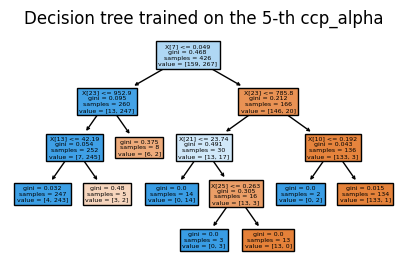

In [17]:
print('the 5th alphas is: ', ccp_alphas[5])
plot_tree(clfs[5], filled=True)
plt.title("Decision tree trained on the 5-th ccp_alpha")
plt.show()

the last alphas is:  0.3272984419327777


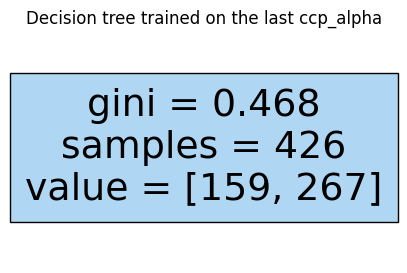

In [18]:
print('the last alphas is: ', ccp_alphas[-1])
plot_tree(clfs[-1], filled=True)
plt.title("Decision tree trained on the last ccp_alpha")
plt.show()

## 3.3 Show the model complexity VS penalty alpha

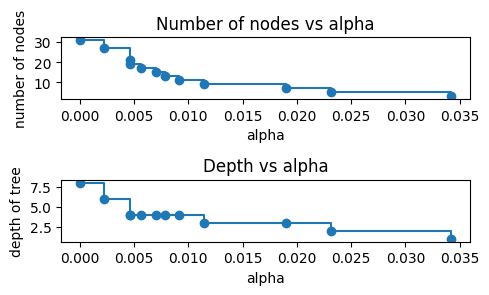

In [19]:
# Two plots showing the relationship between the complexity of a decision tree and the regularization parameter alpha used to control the tree complexity
# 显示决策树复杂度与用于控制树复杂度的正则化参数 alpha 之间关系的两个图

clfs = clfs[:-1] # 从列表 clfs 中删除最后一个元素
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs] 
# 使用列表解析，遍历列表 clfs 中的每个元素 clf，并从中提取决策树的节点数，将结果存储在列表 node_counts 中

depth = [clf.tree_.max_depth for clf in clfs] # 提取决策树的最大深度

fig, ax = plt.subplots(2, 1)
# 创建一个具有两个子图的图表，并将其存储在变量 fig 中，子图将存储在变量 ax 中
# 第一个参数 2 表示要创建两个子图，第二个参数 1 表示每个子图只有一个轴

ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
# 在第一个子图中绘制一个折线图，X轴：ccp_alphas，Y轴：node_counts。
# marker 指定数据点的形状，drawstyle 指定折线的绘制方式

ax[0].set_xlabel("alpha") # 设置第一个子图的 X 轴标签为 "alpha
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")

ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

## 4. General Model Selection using Cross-validation Score

Details of CV, please check documentation: 
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators 

### We use straitified Cross Validation to evaluate a 3-class classificaion problem using the iris dataset
<img src ="https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_003.png" width="600">

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [ ]:
data = pd.read_csv('iris.txt',header=None)  #use tool "read_csv" to read the data in "iris.txt" file. the data is stored in "data"
# 参数 header=None 表示该文件没有列标题，将在后面设置列标题

data.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'class'] #set the column names of the data table 

data.head(10) # 显示 data 数据表的前 10 行数据

In [ ]:
Y = data['class'] # this is our prediction target
# 从 data 数据表中提取 class 列，即鸢尾花的分类，存储在 Y 中。这是我们的预测目标，也就是我们要训练模型去预测的值

X = data.drop(['class'],axis=1)
# 从 data 数据表中删除 class 列，即鸢尾花的分类，并将剩下的特征列存储在 X 中
# 参数 axis=1 表示删除列而不是行

In [ ]:
# 使用 Scikit-learn 库中的 cross_val_score 函数来评估 K 近邻分类器（KNeighborsClassifier）的性能

from sklearn.model_selection import cross_val_score 
# cross_val_score 函数用于评估模型在交叉验证中的性能

clf=KNeighborsClassifier(10) 
# 创建一个名为 clf 的 K 近邻分类器对象，并将 n_neighbors 参数设置为 10

scores = cross_val_score(clf, X, Y, cv=5) 
# 使用 cross_val_score 函数计算 K 近邻分类器 clf 在 X 特征数据和 Y 目标数据上的性能得分
# cv=5 表示使用 5 折交叉验证

print('KNN CV Score:', scores)
# 打印 K 近邻分类器的性能得分，结果是一个数组，每个元素是一次交叉验证的得分

Note
n_neighbors 是 K 近邻算法中的一个参数，用于指定在进行分类时需要考虑的最近邻居的数量。
具体来说，给定一个新的样本，K 近邻算法会在训练数据集中找到距离该样本最近的 n_neighbors 个样本，并根据这些样本的类别进行投票，从而确定该新样本所属的类别。

例如，当 n_neighbors 等于 3 时，K 近邻算法会选择距离该新样本最近的 3 个样本，并根据这些样本的类别进行投票，以确定该新样本所属的类别。

选择适当的 n_neighbors 值对于 K 近邻算法的性能至关重要。
如果 n_neighbors 值太小，则模型可能会过于复杂，对训练数据过拟合；而如果 n_neighbors 值太大，则模型可能会过于简单，无法捕捉到数据的复杂关系

In [ ]:
clf=DecisionTreeClassifier(max_depth=10)
scores = cross_val_score(clf, X, Y, cv=5)
print('DT CV Score:', scores)

### Use all possible classification models for model comparison:

In [ ]:
# 定义了一个步长 h 和一个包含不同分类器的列表 classifiers，
# 这些分类器将用于比较其在同一数据集上的性能

h = 0.02  # step size in the mesh网格中的步长，绘制决策边界时规定不同点之间的间隔距离

# 创建一个名为 names 的字符串列表，包含了要比较的 10 种不同分类器的名称
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

#  创建一个名为 classifiers 的列表，其中包含了 10 个不同的分类器对象，用于进行分类任务
classifiers = [
    KNeighborsClassifier(10), 
    # K 近邻算法分类器，使用 n_neighbors=10 参数进行初始化
    
    SVC(kernel="linear", C=0.025), 
    # 线性支持向量机分类器，使用线性内核 kernel="linear"，并将正则化参数 C 设置为 0.025
    # 线性支持向量机（Linear Support Vector Machine）是一种经典的二分类模型，
    # 主要通过在训练数据中找到一个最佳的超平面（hyperplane），将不同类别的数据点划分到不同的空间区域中

    SVC(gamma=2, C=1),
    # 基于RBF内核的支持向量机分类器，使用gamma=2控制内核系数，将正则化参数 C 设置为 1

    GaussianProcessClassifier(1.0 * RBF(1.0)),
    # 高斯过程分类器，使用 RBF 内核初始化

    DecisionTreeClassifier(max_depth=5),

    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    # 随机森林分类器，将最大深度max_depth设置为 5，使用10个决策树n_estimators，设置max_features=1控制每个决策树节点的最大特征数

    MLPClassifier(alpha=1, max_iter=1000),
    # 多层感知机分类器，正则化参数 alpha 设置为 1，并将最大迭代次数 max_iter 设置为 1000

    # 以下都使用默认参数进行初始化
    AdaBoostClassifier(),
    GaussianNB(), # 高斯朴素贝叶斯分类器
    QuadraticDiscriminantAnalysis(), # 二次判别分析分类器
]

Note
多层感知机分类器（Multi-layer Perceptron，简称 MLP）：
是一种基于前馈神经网络的分类模型，它可以学习到数据集的非线性映射关系，并将不同类别的数据点划分到不同的空间区域中。MLP一般由多个层次组成，包括输入层、隐藏层和输出层，通过调整不同层次之间的连接权重和偏置量来实现模型的训练和预测。MLP的训练过程较为复杂，需要根据数据集的具体情况调整不同的超参数

AdaBoost分类器：
AdaBoost是一种集成学习算法，它通过组合多个弱分类器构建一个强分类器。在每次迭代中，该算法会根据之前分类器的表现对样本进行加权，使得在下一个分类器中，之前分类错误的样本会被赋予更高的权重，这样就能使得后续的分类器更加关注之前分类错误的样本，从而提高整个强分类器的表现。

高斯朴素贝叶斯分类器：
高斯朴素贝叶斯分类器是朴素贝叶斯分类器的一种，它假设特征的概率分布是高斯分布。该算法根据贝叶斯定理计算样本属于每个类别的概率，并将概率最大的类别作为预测结果。与其他朴素贝叶斯分类器类似，该算法也具有较强的分类效果和快速的训练速度。

二次判别分析分类器：
二次判别分析（QDA）分类器也是一种基于贝叶斯定理的分类器。与高斯朴素贝叶斯分类器不同的是，QDA假设每个类别的特征都服从不同的高斯分布，并且每个分布都有自己的协方差矩阵。该算法通过计算每个类别的后验概率来进行分类，从而得出样本最有可能属于哪个类别。与高斯朴素贝叶斯分类器相比，QDA分类器可以更好地处理特征之间的相关性，因为它考虑了每个类别的协方差矩阵。

In [ ]:
# 逐一计算不同分类器在数据集上进行交叉验证的得分
for i in range(len(classifiers)):
    clf=classifiers[i] #use the i-th model in the "classifiers" list
    scores = cross_val_score(clf, X, Y, cv=5)
    print('CV Score of '+ names[i], scores)

### Hold-out with classification report

In [ ]:
from sklearn.metrics import classification_report # this library directly generates precision, recall, f-measure

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix

clf=DecisionTreeClassifier(max_depth=10)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1) 

clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

print(classification_report(y_test, y_pred))

disp = plot_confusion_matrix(clf, X_test, y_test,values_format = '.0f',cmap=plt.cm.Blues)

np.set_printoptions(precision=1) 

print(disp.confusion_matrix)

For multi-class classification problem, micro-average precision scores can be defined as sum of true positives for all the classes divided by the all positive predictions. The positive prediction is sum of all true positives and false positives. Here is how it would look like mathematically:

$𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛𝑀𝑖𝑐𝑟𝑜𝐴𝑣𝑔=\frac{(𝑇𝑃_1+𝑇𝑃_2+𝑇𝑃_3)}{(𝑇𝑃_1+𝑇𝑃_2+𝑇𝑃_3+𝐹𝑃_1+𝐹𝑃_2+𝐹𝑃_3)}$

Macro-average precision score can be defined as the arithmetic mean of all the precision scores of different classes. Here is how it would look like mathematically:

$𝑃𝑟𝑒𝑐𝑖𝑠𝑖𝑜𝑛𝑀𝑎𝑐𝑟𝑜𝐴𝑣𝑔=\frac{(𝑃𝑟𝑒𝑐_1+𝑃𝑟𝑒𝑐_2+𝑃𝑟𝑒𝑐_3)}{3}$

# Summary
## 1. Learn how to get linear regression models: 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

## 2. Learn how to use different evaluation metrics for prediction
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## 3. Learn how to change the regularization penalties (the alpha)
ridge_reg = Ridge(alpha=1, solver="cholesky")

## 4. Learn how to conduct model selection

------------------------------------------------------------------------------------------

## Assignment Week 10 - Due Week 11

### 1. Use the Breast Cancer Wisconsin (Diagnostic) dataset to select the best decision tree structure that has the minimum testing error.

### 2. Does the Breast Cancer Wisconsin (Diagnostic) dataset has imbalanced issue? If so, select the best model according to your own evaluation metric and report the result

### 3. Use 5-fold cross-validation to select the best tree structure for the Breast Cancer Wisconsin (Diagnostic) dataset.

### 4. Use the same dataset, compare the performance of the best tree structure and the Random Forest method. Which model do you prefer?

# 1.

In [41]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score

In [42]:
# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

In [43]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Define depths to try
depths = range(1, 11)

In [45]:
# Train decision trees and record their performance
trees = []
train_scores = []
test_scores = []

In [46]:
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    train_score = balanced_accuracy_score(y_train, tree.predict(X_train))
    test_score = balanced_accuracy_score(y_test, tree.predict(X_test))
    trees.append(tree)
    train_scores.append(train_score)
    test_scores.append(test_score)

In [47]:
# Find the best depth based on test set performance
best_depth = depths[test_scores.index(max(test_scores))]
best_tree = trees[test_scores.index(max(test_scores))]
print(f"Best depth: {best_depth}")
print(f"Test set performance: {max(test_scores)}")

Best depth: 4
Test set performance: 0.9439895185063871


# 2. 

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

In [82]:
df = pd.DataFrame(X, columns=data.feature_names)
df['target'] = y

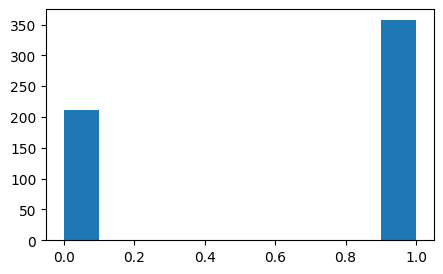

In [83]:
# Check for class imbalance
plt.hist(df['target'])
plt.show()

As can be seen from the figure, there is a significant gap between the number of benign and malignant cases in the dataset, so there is an imbalanced issue.

In [77]:
# Evaluate the best tree using our own evaluation metric
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [78]:
# Train a decision tree model
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [79]:
# Evaluate the decision tree model
dt_f1 = f1_score(y_test, dt.predict(X_test))
dt_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

In [80]:
# Print the F1 score and AUC-ROC score for the decision tree model
print(f"Decision tree F1 score: {dt_f1:.3f}")
print(f"Decision tree AUC-ROC score: {dt_auc:.3f}")

Decision tree F1 score: 0.958
Decision tree AUC-ROC score: 0.935


# 3.

In [ ]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer

In [ ]:
# Use 5-fold cross-validation to select the best decision tree
depths = [1, 2, 3, 4, 5]
trees = []
scores = []

In [58]:
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    score = cross_val_score(tree, X, y, cv=5, scoring='balanced_accuracy')
    trees.append(tree)
    scores.append(score.mean())

In [59]:
best_depth = depths[scores.index(max(scores))]
best_tree = trees[scores.index(max(scores))]
print(f"Best depth: {best_depth}")
print(f"Cross-validation performance: {max(scores)}")

Best depth: 2
Cross-validation performance: 0.9206515579263697


# 4.

In [61]:
from sklearn.ensemble import RandomForestClassifier

In [62]:
# Train the best decision tree
best_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
best_tree.fit(X_train, y_train)
train_score_tree = balanced_accuracy_score(y_train, best_tree.predict(X_train))
test_score_tree = balanced_accuracy_score(y_test, best_tree.predict(X_test))

In [63]:
# Train a random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_train, y_train)
train_score_rf = balanced_accuracy_score(y_train, rf.predict(X_train))
test_score_rf = balanced_accuracy_score(y_test, rf.predict(X_test))

print(f"Decision Tree Test set performance: {test_score_tree}")
print(f"Random Forest Test set performance: {test_score_rf}")

Decision Tree Test set performance: 0.9439895185063871
Random Forest Test set performance: 0.9580740255486406


So I prefer Random Forest.